In [839]:
#import libraries

import pandas as pd
import numpy as np 

#modeling
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#graphing
import matplotlib.pyplot as plt 
import seaborn as sns 

#querying
import sqlite3
from sqlite3 import Error
from pathlib import Path

#stats
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chi2_contingency

#dashboarding
import pickle

In [845]:
#reading in our data 

data = pd.read_csv('Churn Modeling.csv',sep = ',')

### Exploratory Data Analysis & Data Pre-processing
#### Step 1: Looking at dropping non-informative data

In [182]:
#looking at our data
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,West,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Central,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,West,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,West,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Central,Female,43,2,125510.82,1,1,1,79084.10,0


##### Observation - RowNumber, CustomerId & Surname: 
RowNumber  and CustomerId columns have unique values for each customer, so we can safely drop these as these won't add anything to our models and may actually cause to overfit later on 

While Surname doesn't immediately appear that useful, given the high number of repeat Surnames in the dataset, one thought would be to see if it would be possible to figure out with some degree of certainty if some people sharing the same surname that are in the same Geography might be married / part of the same family, and may have a higher / lower likelihood of churning as a group

**Class Imbalance:** We notice a 4:1 class imbalance in the Exited variable, which will need to be addressed later on 
during model training 

In [846]:
#looking at number of unique CustomerId's, RowNumbers and Surnames in the dataset
print('Number of repeat CustomerId:', data.shape[0] - data.CustomerId.nunique())
print('Number of repeat RowNumber:',data.shape[0] - data.RowNumber.nunique())
print('Number of repeat Surname:',data.shape[0] - data.Surname.nunique())
#dropping these first two columns as a result
data.drop(['CustomerId','RowNumber'], axis = 1, inplace = True)

Number of repeat CustomerId: 0
Number of repeat RowNumber: 0
Number of repeat Surname: 7068


In [184]:
#looking at class imbalance in Exited variable - 4:1 class imbalance
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

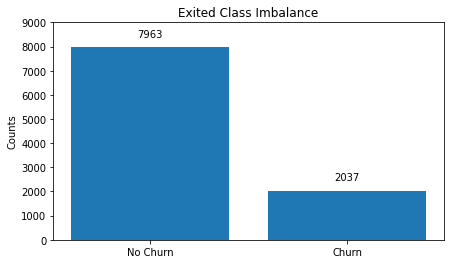

In [972]:
#visualizing Exited class imbalance
plt.figure(figsize = (7,4))
plt.bar(['No Churn','Churn'], [7963,2037])
plt.title('Exited Class Imbalance')
plt.ylabel('Counts')
for x,y in zip(['No Churn','Churn'], [7963,2037]):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,9000)
plt.show()

Let's create a correlation heatmap to build some high level intuition of some of the linear relationships in our dataset. In order to create heatmap we map qualitative variables to numeric to extract relationships on those mappings


Text(0.5, 1.0, 'Numeric Variables Correlation Heatmap')

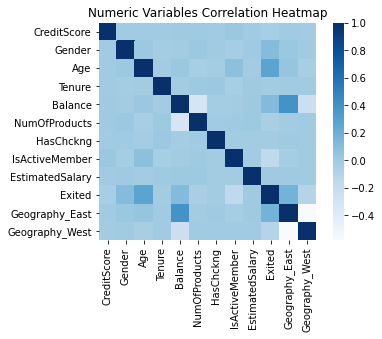

In [847]:
#data mapping and dummifyng for Gender and Geography variables respectively

data['Gender'] = (data['Gender'] == 'Female') * 1
data = pd.get_dummies(data, prefix=['Geography'], columns=['Geography'], drop_first = True)

#creating correlation heatmap 
ax = plt.axes()
correlation = data.corr()
sns.heatmap(correlation, square = True, cmap = 'Blues', ax = ax)
plt.title('Numeric Variables Correlation Heatmap')


#### Step 2: Looking for outliers

##### Observation - Age:

We notice one impossible value of 190 in Age variable. The true value can't be 19 because the value for Tenure, assuming this is not also a typo, is 9 for this customer, and the minimum age to use bank products is 18. Given this data looks to be missing at random, and considering the relatively strong linear relationship between Age and IsActiveMember in our correlation however, we will choose to impute Age using simple linear regression with our other x variables

In [128]:
data.loc[data['Age'] == 190]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
27,28,15700772,Nebechi,571.0,West,Male,190,9,0.0,2,0,0,38433.35,0


In [192]:
#looking at stronger correlations values specifically with respect to Age
def show_correlations(variable, threshold = 0.05):
    return data.corr()[[variable]].loc[(data.corr()[[variable]][variable] > 0.05) 
                                       | (data.corr()[[variable]][variable] < -0.05)]
show_correlations('Age')

,Age
Age,1.000000
IsActiveMember,0.084690
Exited,0.284525


In [849]:
#using linear regression imputation using isActiveMember
data_no_missing = data.loc[data['Age'] != 190]
X_lnr = data_no_missing[['IsActiveMember']]
y_lnr = data_no_missing['Age']

#splitting ur data
x_train_lnr, x_test_lnr, y_train_lnr, y_test_lnr = train_test_split(X_lnr, y_lnr, test_size = 0.2, random_state = 4)
lnr = LinearRegression()
lnr.fit(x_train_lnr, y_train_lnr)
#extracting observation we want to predict
predict_obs = pd.DataFrame(data.loc[data['Age'] == 190]['IsActiveMember'])
predicted_value = lnr.predict(predict_obs)[0]
print('Predicted value is:', predicted_value)
#replace with our predicted value
data['Age'] = data['Age'].replace([190],predicted_value)

Predicted value is: 37.9598445595855


In [740]:
#creating dataframe to visualize Exited percentages by Age subgroup
bins = [10,20,30,40,50,60,70,80,90,102]
age_groups = data.groupby([pd.cut(data.Age, bins)])['Exited'].sum() / data.groupby([pd.cut(data.Age, bins)])['Exited'].size()
age_groups = pd.DataFrame(age_groups).reset_index()

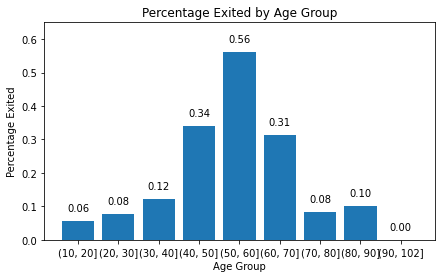

In [973]:
#creating our Age vs Exited bar chart
plt.figure(figsize = (7,4))
plt.bar(age_groups['Age'].astype(str), age_groups['Exited'])
plt.title('Percentage Exited by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage Exited')
for x,y in zip(age_groups['Age'].astype(str),age_groups['Exited']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,.65)
plt.show()

##### Observation - CreditScore:

We notice one customer with a CreditScore = 865. While per the provided data dictionary the max value for a FICO score should be 850, we can keep this observation as this value is not signficantly different by any useful outlier measure i.e. Third Quartile + 1.5 * IQR from CreditScore variable and can therefore be kept. We also note per outside research that FICO scores do occasionally surpass 850, so this is slightly unsurprising

In [105]:
#looking at outlier
data.loc[data['CreditScore'] > 850]

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
8,He,865.0,West,Male,44,4,142051.07,2,0,1,74940.5,0


##### Observations - Tenure:

We notice one customer with Tenure of 30 and Age of 29 which is impossible and indicates either either the Tenure or Age value (or both) are incorrect. We will choose to treat the Tenure value of 30 as a data entry mistake and look for ways to impute this value. Given the above correlation heatmap doesn't show any particularly strong linear relationships between Tenure and the other x variables in our dataset, we will choose to impute this incorrect value by the mean

In [113]:
#looking at outlier
data.loc[data['Tenure'] > 20]

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
7,Obinna,376.0,East,Female,29,30,115046.74,4,1,0,119346.88,1


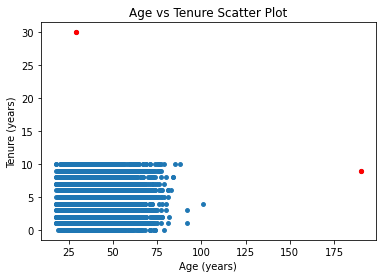

In [786]:
#creating scatter plot of Age vs. Tenure to identify outliers
plt.scatter(data['Age'],data['Tenure'], marker='o', s=15)
plt.scatter(29, 30, c='red', marker='o', s=18)
plt.scatter(190, 9, c='red', marker='o', s=18)
plt.title('Age vs Tenure Scatter Plot')
plt.xlabel('Age (years)')
plt.ylabel('Tenure (years)')
plt.show()

There are several other observations where Tenure minus Age is lower than eighteen, which should be impossible given no minors should be legally allowed to use Bank products. Given Tenure is defined as 'Length of client relationship' in the data dictionary and not 'Amount of years using bank products' we will give this one a pass 

In [701]:
#looking at potential other outliers
data.loc[(data['Age'] - data['Tenure'] < 18)].shape

(322, 13)

In [193]:
#no discernible linear relationships between Tenure and other x variables
show_correlations('Tenure')

,Tenure
Tenure,1.0


In [850]:
#replacing this value
data['Tenure'] = data['Tenure'].replace([30], data['Tenure'].loc[data['Tenure'] < 30].mean())

(array([ 413., 1035., 1048., 1009.,  988., 1013.,  967., 1028., 1025.,
        1474.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

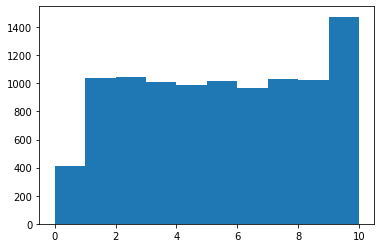

In [983]:
#creating histogram of Tenure
plt.hist(data['Tenure'])

##### Observation - Balance:

From our histogram of the Balance variable, there don't look to be any outliers to address, and it makes sense 
that a large amount of customers would have bank balances of zero

Text(0, 0.5, 'Count')

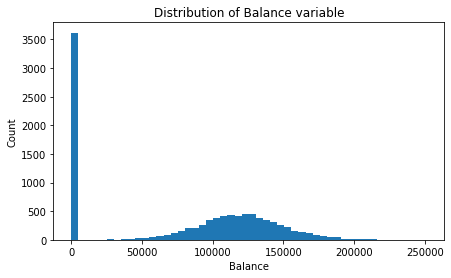

In [974]:
#let's look at distribution of our Balance variable 
plt.figure(figsize = (7,4))
_ = plt.hist(data['Balance'], bins = 50)
plt.title('Distribution of Balance variable')
plt.xlabel('Balance')
plt.ylabel('Count')

##### Observation - NumOfProducts:

The observation that all 60 customers using 4 products ended up churning is very surprising. Taking a closer look at these 60 customer observations doesn't make anything about these customers jump out except that they all churned. We expect NumOfProdcuts to be a highly predictive feature in our models later on

In [762]:
#creating dataframe to visualize Churn by NumOfProducts subgroup 
num_products_groups = data.groupby('NumOfProducts')['Exited'].sum() / data.groupby('NumOfProducts')['Exited'].size()
num_products_groups = num_products_groups.reset_index()

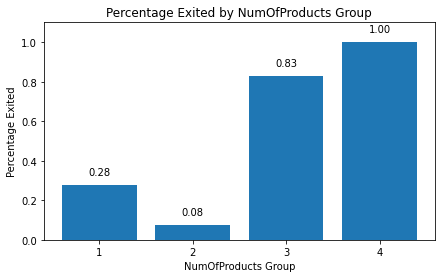

In [975]:
#visualize Churn rates by NumOfProducts subgroup 
plt.figure(figsize = (7,4))
plt.bar(num_products_groups['NumOfProducts'].astype(str), num_products_groups['Exited'])
plt.title('Percentage Exited by NumOfProducts Group')
plt.xlabel('NumOfProducts Group')
plt.ylabel('Percentage Exited')
for x,y in zip(num_products_groups['NumOfProducts'].astype(str),num_products_groups['Exited']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,1.1)
plt.show()

##### Observation - IsActiveMember:

We note right off the bat that customers marked as being inactive are twice as likely to churn than active customers

In [496]:
#looking at Churn rates by IsActiveMember subgroup
data.groupby('IsActiveMember')['Exited'].sum() / data.groupby('IsActiveMember')['Exited'].size() 

IsActiveMember
0    0.268509
1    0.142691
Name: Exited, dtype: float64

##### Observation - EstimatedSalary:

Somewhat interesting there are no customers with estimated salaries above 200k. Wonder if this is the way that the data was queried or due to something else

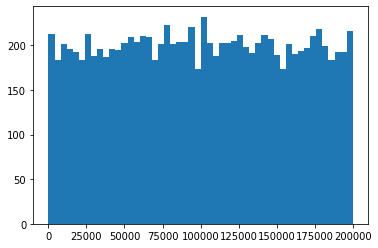

In [208]:
#looking at distribution of EstimatedSalary variable
_ = plt.hist(data['EstimatedSalary'], bins = 50)

#### Observation - Gender

We observe that female-identifying customers are 1.5 times more likely to churn than their male counterparts. We expect Gender to be an important predictor later on

In [705]:
#looking at Churn rates by Gender subgroup
data.groupby('Gender')['Exited'].mean()

Gender
0    0.164805
1    0.250496
Name: Exited, dtype: float64

#### Step 3: Looking for missing data

##### Observations:

We notice three missing values in CreditScore variable. Looking at these observations, while it initially stands out that these missing values all belong to Male customers above the age of 35 not from the East Region, we observe that these are all customers with salaries > 120k, using at least one banking product, with two having non-insignificant savings balances of >80k, which tells us these are people that should realistically not only have a CreditScore but have a CreditScore that is not too low. We will therefore choose to impute these missing values with the mean 

We notice one CreditScore value of 305 and one of 865 which while being lower and greater than the 350 to 850 range specified in the provided data dictionary is left untreated given these values are not significantly different from standard outlier measures 

In [215]:
#looking at missing data 

missing_data = pd.DataFrame(data.isna().sum(), columns = ['Missing Values'])
missing_data.loc[missing_data['Missing Values'] > 0]

,Missing Values
CreditScore,3


In [123]:
#looking at three missing CreditScore values 
data.loc[data.CreditScore.isnull()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
459,460,15662976,Lettiere,NaN,Central,Male,37,8,0.00,1,1,1,186062.36,0
497,498,15733616,Sopuluchukwu,NaN,West,Male,40,5,80613.93,1,1,1,142838.64,0
625,626,15604119,Alderete,NaN,Central,Male,35,7,110349.82,1,0,0,126355.80,0


In [216]:
#no > |0.05| correlations so mean imputation instead of linear regression imputation should make more sense 
show_correlations('CreditScore')

,CreditScore
CreditScore,1.0


In [851]:
#imputing missing values to the mean
data.CreditScore.fillna(data.CreditScore.mean(), inplace = True)

In [793]:
#looking at potential other CreditScore outliers - we decide these are OK to keep per above comment
data.loc[(data['CreditScore'] > 850) | (data['CreditScore'] < 350)]

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
8,He,865.0,West,Male,44,4,142051.07,2,0,1,74940.50,0
90,Heap,305.0,Central,Female,44,5,0.00,3,1,1,174205.22,1


### Feature Engineering
#### Step 1: Adding in ethnicity frequency information by Surname from census data 

We will cross-reference census.gov data on Surnames to add in ethnicity frequency information for that Surname and look to see if this can yield additional useful information for our models

Source: https://www.census.gov/topics/population/genealogy/data/2010_surnames.html

In [853]:
#reading in our census data 
census = pd.read_csv('Names_2010Census.csv', sep = ',')

#creating SQL database 
Path('census.db').touch()
conn = sqlite3.connect('census.db')
c = conn.cursor()
census.to_sql('census', conn, if_exists='append', index = False)

Our SQL Database has 162,254 total surname records

In [237]:
#looking at size of our Census dataframe
c.execute('''SELECT count(*) FROM census''').fetchall()

[(162254,)]

#### Observation: Ethnicity variables

We notice several of the ethnicity variables have observations with (S) in cases where the information was suppressed for confidentiality reasons per the census.gov data dictionary. Since we observe these (S) values occur in cases where another or several of the other ethicity groups already account for 90% or more of the Surname population, we will impute these to zero

In [854]:
#merging dataframes on Surname

#transforming Surname in census data 
census.rename({'name':'Surname'}, axis = 1, inplace = True)
census['Surname'] = census['Surname'].astype(str)
census['Surname'] = census.Surname.apply(lambda x: x.title())

#dropping superfluous census columns
census.drop(['rank','count','cum_prop100k'], axis = 1, inplace = True)

#replacing suppressed values with zero
cols = ['pctwhite','pctblack','pctapi','pctaian','pct2prace','pcthispanic']
census[cols] = census[cols].replace({'(S)':0})
census[cols] = census[cols].astype(np.float32)
data2 = pd.merge(data, census, how = 'left', on = 'Surname')
data2['prop100k'] = data2['prop100k'].fillna(0.01)

We still have ~850 Surnames in the dataset that do not appear in the census dataset and therefore have missing values for our demographic variables. We will choose to impute these missing values to the average prevalence of that ethnicity group in the US per https://www.census.gov/quickfacts/fact/table/US/PST045219

In [412]:
#looking at number of unique Surnames with no demographic information 
data2.loc[data2['pctwhite'].isnull()].groupby('Surname')[['Age']].count().shape[0]

845

In [855]:
#creating imputation values
census_pctwhite = 59.1
census_pctblack = 13.2
census_pctaian = 1.3
census_pctapi = 6.1
census_pct2prace = 2.6
census_pcthispanic = 17.7

#imputing 
data2['pctwhite'] = data2['pctwhite'].fillna(census_pctwhite)
data2['pctblack'] = data2['pctblack'].fillna(census_pctblack)
data2['pctaian'] = data2['pctaian'].fillna(census_pctaian)
data2['pctapi'] = data2['pctapi'].fillna(census_pctapi)
data2['pct2prace'] = data2['pct2prace'].fillna(census_pct2prace)
data2['pcthispanic'] = data2['pcthispanic'].fillna(census_pcthispanic)

#### Step 2: Looking at extracting additional information from Surname

We noted earlier there were ~7k observations with surnames appearing elsewhere in the dataset. We will cross-reference census.gov data on frequency of surnames to see if we may create an additonal variable that captures if we think with a reasonable degree of certainty that some duplicate Surnames are potentially relatives, and therefore might exhibit higher / lower group tendencies to churn together

Source: https://www.census.gov/topics/population/genealogy/data/2010_surnames.html

In [275]:
#looking at cutoff values to determine best cutoff value to create Relative variable
same_surnames_mean = data2.loc[data2['prop100k'] <= 0.08].\
    groupby('Surname')[['Age','Exited']].agg({'Age':'count','Exited':'sum'}).reset_index()
same_surnames_mean.rename({'Age':'Count'}, axis = 1, inplace = True)
same_surnames_mean['Perc_Exited'] = same_surnames_mean.Exited / same_surnames_mean.Count

#### Observation: Chi-squared test

We will use multiple chi-squared tests using different prop100k cutoff values to find the best subset of our data that shows the greatest dependence with our Exited variable

In [667]:
#creating list of Surnames with counts > 1 in our dataset

surnames = data2.groupby('Surname')['Age'].count().reset_index()
surnames.rename({'Age':'Count'}, axis = 1, inplace = True)
surnames = surnames.loc[surnames['Count'] > 1]
surnames = list(surnames.Surname)
len(surnames)

1374

In [668]:
#performing chi square test

def chi_squared_test(cutoff):

    #splitting data
    same_surnames_exited = data2.loc[(data2['prop100k'] <= cutoff) & 
                                    data2['Surname'].isin(surnames)][['Exited']]
    same_surnames_exited_index = list(same_surnames_exited.index.values)
    data_exited = data2[~data2.index.isin(same_surnames_exited_index)][['Exited']]
    
    #creating contingency table 
    data_chi_test = pd.DataFrame({'Not_Related':[data_exited.sum()[0],
                                           data_exited.loc[data_exited['Exited'] == 0].shape[0]],
                                  'Related':[same_surnames_exited.sum()[0],
                                             same_surnames_exited.loc[same_surnames_exited['Exited'] == 0].shape[0]]},
                            index = ['Exited','Did_Not_Exit'])
    #return data_chi_test
    stat, p, dof, expected = chi2_contingency(data_chi_test)
    return p
chi_squared_test(0.055)

,Not_Related,Related
Exited,1540,497
Did_Not_Exit,5963,2000


(0.0, 24.0)

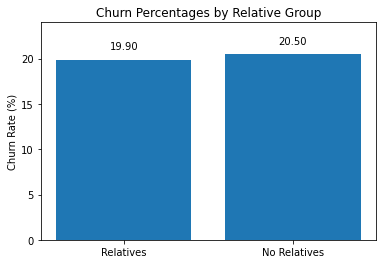

In [963]:
#visualizing churn rates by Relative group
plt.bar(['Relatives','No Relatives'],[19.9,20.5])
plt.title('Churn Percentages by Relative Group')
plt.ylabel('Churn Rate (%)')

for x,y in zip(['Relatives','No Relatives'],[19.9,20.5]):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.ylim(0,24)

In [ ]:
#splitting data
same_surnames_exited = data2.loc[(data2['prop100k'] <= 0.055) & 
                                data2['Surname'].isin(surnames)][['Exited']]
same_surnames_exited_index = list(same_surnames_exited.index.values)
data_exited = data2[~data2.index.isin(same_surnames_exited_index)][['Exited']]

#creating contingency table 
data_chi_test = pd.DataFrame({'Not_Related':[data_exited.sum()[0],
                                       data_exited.loc[data_exited['Exited'] == 0].shape[0]],
                              'Related':[same_surnames_exited.sum()[0],
                                         same_surnames_exited.loc[same_surnames_exited['Exited'] == 0].shape[0]]},
                        index = ['Exited','Did_Not_Exit'])
data_chi_test

#### Observation: Chi-squared test

We can see a cutoff values of ~0.055 and ~0.15 for prop100k yields the lowest p-value, though this p-value is still nowhere near significant. Still, we will use the lower cutoff value of these two to create a 'Relative' variable where we think that person may have with a reasonable degree of certainty a relative in the dataset

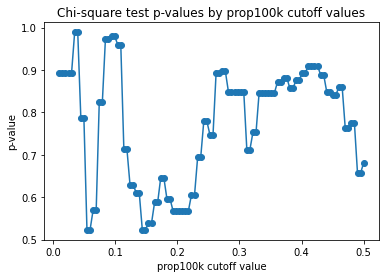

In [663]:
#looking at p-values of chi square tests of our engineered Relative variable vs Exited for different cutoff
#values of prop100k
cutoffs = list(np.linspace(0.01,0.5,100))
pvalues = []
for cutoff in cutoffs:
    pvalues.append(chi_squared_test(cutoff))
plt.plot(cutoffs, pvalues, '-o')
plt.title('Chi-square test p-values by prop100k cutoff values')
plt.xlabel('prop100k cutoff value')
plt.ylabel('p-value')
plt.show()

In [857]:
#creating Relative variable 

data2['Relative'] = np.where((data2['prop100k'] <= 0.055) & 
                                    data2['Surname'].isin(surnames), 1, 0)

In [858]:
#dropping Surname and prop100k as these variables could potentially now cause our models to overfit random noise
data2.drop(['Surname','prop100k'], axis = 1, inplace = True)

### Model Training
#### Step 1: Splitting data, parameterizing and training models

We set train_test_split stratify parameter to True to ensure our models see the same proportion of 1's and 0's observations in each training phase 

In [859]:
#preparing our data

y = data2['Exited']
X = data2.drop(['Exited'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y, random_state = 42)


In [867]:
#pickling our xtest data for DashApp & Flaskapp use

with open('x_test.pickle','wb') as xtest_path:
    pickle.dump(x_test, xtest_path)

#### Step 2: Linear Models - Logistic Regression

In [570]:
#stratify = True in train_test_split
lr = LogisticRegressionCV(cv = 5, class_weight = class_weights, max_iter = 200)

lr.fit(x_train, y_train)
cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'roc_auc')

array([0.77785029, 0.76720958, 0.73081834, 0.74725926, 0.71798236])

In [ ]:
#stratifield KFold cross validation
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=4)
class_weights = {0:1, 1:4}

i = 1
cv_score = []
for train_index, test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(class_weight = class_weights, max_iter = 500, solver = 'liblinear')
    lr.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)    
    i+=1

In [ ]:
#using trained LogisticRegression model to predict x_test
lr_preds = lr.predict(x_test)

In [571]:
#lr feature importances
sorted(list(zip(lr.coef_.tolist()[0], list(X.columns.values))), key = lambda x: x[0], reverse = True)

[(0.07114631917082671, 'Age'),
 (0.006699973271303987, 'Geography_East'),
 (0.005997241366841225, 'Gender'),
 (4.818541274918517e-06, 'Balance'),
 (1.133832923385253e-06, 'EstimatedSalary'),
 (-0.0007159598365859097, 'CreditScore'),
 (-0.0009815391039313685, 'HasChckng'),
 (-0.0012122200958022706, 'Relative'),
 (-0.0014150629322032282, 'pctaian'),
 (-0.0025956312459188766, 'NumOfProducts'),
 (-0.0029270881994871885, 'Tenure'),
 (-0.004176936489312334, 'pct2prace'),
 (-0.005590362837853389, 'Geography_West'),
 (-0.010830527265412697, 'IsActiveMember'),
 (-0.029090450199080846, 'pctapi'),
 (-0.02931088001666711, 'pctblack'),
 (-0.02986239831975608, 'pctwhite'),
 (-0.03218563731137807, 'pcthispanic')]

Logistic Regression yields OK results but feels like we can go further with tree-based models. This was somewhat expected from lack of discernible linear relationships seen earlier. We will nonetheless use this as baseline going forward and will look at tree-based models next 

In [ ]:
#cross validating our performance metrics
print('LR recall std is',np.std(cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'recall')))
print('LR precision std is',np.std(cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'precision')))
print('LR roc_auc std is',np.std(cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'roc_auc')))

print('LR recall mean is',np.mean(cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'recall')))
print('LR precision mean is',np.mean(cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'precision')))
print('LR roc_auc mean is',np.mean(cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'roc_auc')))

In [953]:
#pickling our LogisticRegression model

with open('lr.pickle','wb') as lr_path:
    pickle.dump(lr, lr_path)

#### Step 3: Horizontal tree-ensembling methods, RandomForestClassifier

In [569]:
#stratify = True in train_test_split
#training our model
rfc = RandomForestClassifier(n_estimators = 400, criterion = 'gini', max_depth = 5, class_weight = class_weights)
rfc.fit(x_train, y_train)
cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'roc_auc')

array([0.88710913, 0.85400942, 0.82133534, 0.86594709, 0.82618695])

In [ ]:
#stratified KFold cross validation
i = 1
cv_score_rfc = []
for train_index, test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    rfc = RandomForestClassifier(n_estimators = 400, criterion = 'gini', max_depth = 5, class_weight = class_weights)
    rfc.fit(xtr,ytr)
    score = roc_auc_score(yvl,rfc.predict(xvl))
    print('ROC AUC score:',score)
    cv_score_rfc.append(score)    
    i+=1

In [ ]:
#cross validating our performance metrics
print('RFC recall std is',np.std(cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'recall')))
print('RFC precision std is',np.std(cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'precision')))
print('RFC roc_auc std is',np.std(cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'roc_auc')))

print('RFC recall mean is',np.mean(cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'recall')))
print('RFC precision mean is',np.mean(cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'precision')))
print('RFC roc_auc mean is',np.mean(cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'roc_auc')))

In [572]:
#looking at confusion matrix for RFC
from sklearn.metrics import confusion_matrix
rfc_predictions = rfc.predict(x_test)
confusion_matrix(y_test, rfc_predictions)

array([[2111,  517],
       [ 164,  508]])

In [576]:
#feature importances
sorted(list(zip(rfc.feature_importances_, X.columns)), key = lambda x: x[0], reverse = True)

[(0.41292136904280247, 'Age'),
 (0.24932805756818194, 'NumOfProducts'),
 (0.07903090547160713, 'IsActiveMember'),
 (0.07208709621768453, 'Geography_East'),
 (0.06118919228007895, 'Balance'),
 (0.02260077257041998, 'Gender'),
 (0.01780764596733752, 'Geography_West'),
 (0.01650977777474995, 'CreditScore'),
 (0.013984538439036638, 'EstimatedSalary'),
 (0.010094720528449778, 'pctwhite'),
 (0.008560983641185647, 'pcthispanic'),
 (0.007698131487386511, 'pct2prace'),
 (0.007474803553547569, 'pctapi'),
 (0.007022188327784043, 'pctblack'),
 (0.006542253591307239, 'pctaian'),
 (0.005606573149553197, 'Tenure'),
 (0.000987240228214629, 'HasChckng'),
 (0.0005537501606723343, 'Relative')]

In [952]:
#pickling our RandomForestClassifier model

with open('rfc.pickle','wb') as rfc_path:
    pickle.dump(rfc, rfc_path)

#### Step 4: Vertical tree-ensembling methods, XGBoost

In [ ]:
#nstantiating XGBoostClassifier model and defining parameters 
from xgboost import XGBClassifier

xgboost = XGBClassifier(silent=False, 
                      scale_pos_weight=4,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=300, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
xgboost.fit(x_train, y_train)

In [ ]:
#predicting x_test
preds = xgboost.predict(x_test)

In [603]:
#feature importances
sorted(list(zip(xgboost.feature_importances_, X.columns)), key = lambda x: x[0], reverse = True)

[(0.19937824, 'Age'),
 (0.16566657, 'NumOfProducts'),
 (0.103652954, 'IsActiveMember'),
 (0.076023296, 'Geography_East'),
 (0.06141522, 'Balance'),
 (0.05198584, 'Geography_West'),
 (0.046013273, 'Gender'),
 (0.030741615, 'pctapi'),
 (0.03016604, 'HasChckng'),
 (0.02868764, 'CreditScore'),
 (0.02810993, 'Tenure'),
 (0.027568739, 'EstimatedSalary'),
 (0.025700673, 'pcthispanic'),
 (0.025527578, 'pctwhite'),
 (0.025152216, 'pctaian'),
 (0.025027564, 'pctblack'),
 (0.024923433, 'pct2prace'),
 (0.024259115, 'Relative')]

In [ ]:
#cross validating performance metrics
print('XGB recall std is',np.std(cross_val_score(xgboost, x_test, y_test, cv = 5, scoring = 'recall')))
print('XGB precision std is',np.std(cross_val_score(xgboost, x_test, y_test, cv = 5, scoring = 'precision')))
print('XGB roc_auc std is',np.std(cross_val_score(xgboost, x_test, y_test, cv = 5, scoring = 'roc_auc')))

print('XGB recall mean is',np.mean(cross_val_score(xgboost, x_test, y_test, cv = 5, scoring = 'recall')))
print('XGB precision mean is',np.mean(cross_val_score(xgboost, x_test, y_test, cv = 5, scoring = 'precision')))
print('XGB roc_auc mean is',np.mean(cross_val_score(xgboost, x_test, y_test, cv = 5, scoring = 'roc_auc')))

In [616]:
#getting predicted probabilities dataframe from xgboost
xgbpreds = pd.DataFrame(xgboost.predict_proba(x_test)[:,:], columns = ['No Churn','Churn'])
xgbpreds.loc[xgbpreds['Churn'] > 0.2].shape

(2568, 2)

In [949]:
#creating dataframe to pickle for our Dash App / Flask App 
df_ids = pd.concat([data1.loc[x_test.index.values,['CustomerId','Geography']], x_test], axis = 1)
df_ids.drop(cols, axis = 1, inplace = True)
df_ids.drop(['Relative','Geography_East','Geography_West', 'HasChckng'], axis = 1, inplace = True)
xgbpreds_rank = xgbpreds.drop('Action', axis = 1)
xgbpreds_rank.reset_index(drop=True, inplace=True)
df_ids.reset_index(drop=True, inplace=True)
pickle_df = pd.concat([df_ids, xgbpreds_rank], axis = 1)
pickle_df.sort_values(by = 'Churn', ascending = False, inplace = True)
pickle_df['rank'] = pickle_df.index.values + 1
pickle_df.rename({'NumOfProducts':'NumProducts','IsActiveMember':'IsActive','EstimatedSalary':'Salary'}, 
                 axis = 1, inplace = True)
pickle_df.drop(['No Churn','Tenure'], axis = 1, inplace = True)
pickle_df['Churn'] = (pickle_df['Churn'] * 100).astype(str).apply(lambda x: x[:4])

In [951]:
#pickling this dataframe
with open('df_ids.pickle','wb') as df_ids_path:
    pickle.dump(pickle_df, df_ids_path)

In [816]:
#concatenating our true y values to our predict proba df from XGBoostClassifier
y_test2 = y_test.reset_index()
y_test2.drop('index', axis = 1, inplace = True)
merged = pd.concat([xgbpreds, y_test2], axis = 1)
merged.drop('Action', axis = 1, inplace = True)

In [614]:
#looking at xgboost confusion matrix
confusion_matrix(y_test, preds)

array([[2111,  517],
       [ 155,  517]])

In [840]:
#pickling our xgb model

with open('xgboost.pickle','wb') as xgb_path:
    pickle.dump(xgboost, xgb_path)

#### Step 5: Visualizing ROC_AUC Curves

In [673]:
#getting predicted probabilities for each of our models
probas_lr = lr.predict_proba(x_test)[:, 1]
probas_rfc = rfc.predict_proba(x_test)[:, 1]
probas_xgb = xgboost.predict_proba(x_test)[:, 1]

In [674]:
#defining prediction function
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

In [681]:
#LogisticRegression
roc_values_lr = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas_lr)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values_lr.append([tpr, fpr])
tpr_values_lr, fpr_values_lr = zip(*roc_values_lr)

In [682]:
#RandomForestClassifier
roc_values_rfc = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas_rfc)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values_rfc.append([tpr, fpr])
tpr_values_rfc, fpr_values_rfc = zip(*roc_values_rfc)

In [683]:
#XGBClassifier
roc_values_xgb = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas_xgb)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values_xgb.append([tpr, fpr])
tpr_values_xgb, fpr_values_xgb = zip(*roc_values_xgb)

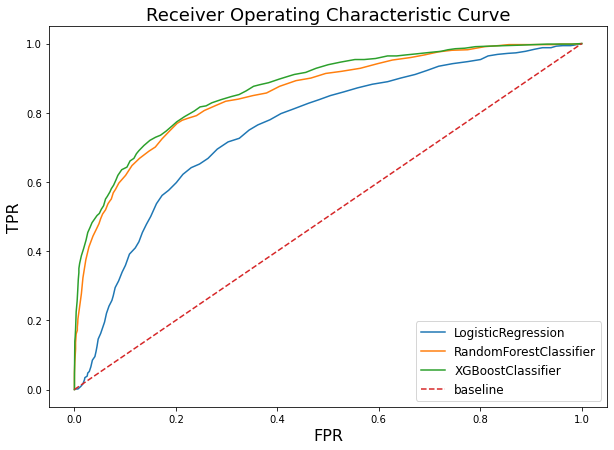

In [687]:
#creating ROC_AUC plot
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values_lr, tpr_values_lr, label = 'LogisticRegression')
ax.plot(fpr_values_rfc, tpr_values_rfc, label = 'RandomForestClassifier')
ax.plot(fpr_values_xgb, tpr_values_xgb, label = 'XGBoostClassifier')
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
ax.legend()
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

### Tuning & Defining Actionable Business Strategy

Creating function that determines whether or not to apply a promo to a customer based on their likelihood of churning. We use the below cost function to quantify for different parameters the expected value of applying a promotional strategy to our customer. Future iterations of this cost function should build out a DCF analysis-like model on Customer Lifetime Value (CLV) incorporating expected future cash flows from the customer in order to improve on the below quantification of the cost of churn. Please refer to the slide deck for greater detail on this cost function 

In [ ]:
#cost function

def action_determination(cost_of_churn = 5, cost_of_promo = 1, effectiveness_of_promo = 1, 
                         cost_of_wrong_action = 0.1, preds = xgbpreds, top = -1):
    #creating function that determines whether or not to apply a promo to a customer based 
    #on their likelihood of churning
    #must pass a DataFrame of predict_proba with column names Churn and Not Churn
    
    #cost of wrong action captures if the customer was not going to churn in the first place and churns as a 
    #result of the promo 
    
    df = preds.sort_values(by = 'Churn', ascending = False)
    
    #action column creates actions by comparing the greater expected value of Action vs No action 
    #based on our pred_proba 
    
    df['Action'] = np.where(df['Churn'] * (cost_of_churn * effectiveness_of_promo) - 
                             df['No Churn'] * (cost_of_promo + cost_of_wrong_action) >
                            df['No Churn'] * (cost_of_promo + cost_of_wrong_action) -
                             df['Churn'] * (cost_of_churn * effectiveness_of_promo),
                           1, 0)

    df['Estimated_Benefit'] = np.where(df['Action'] == 1, (df['Churn'] * cost_of_churn * effectiveness_of_promo) - 
                                                         (cost_of_promo + cost_of_wrong_action),
                                      (df['No Churn'] * (cost_of_promo + cost_of_wrong_action) - 
                                      (df['Churn'] * cost_of_churn * effectiveness_of_promo)))

    print('There are {} customers for which we recommend taking an action'.format(df.Action.sum()))
    print('\n')
    print('The Customers we recommend taking a promotional action on include:')
    return df.loc[df['Action'] == 1].sort_values(by='Estimated_Benefit', ascending = False)[:top]
    
action_determination(1000, 500, 0.8, 1, xgbpreds, 50)

End of this notebook - please check out my slides for some of the business recommendations from this analysis. Thanks for reading!